<center>

*******************************************************************************************
    
### Correlation Analysis of Nasdaq Nordic Stocks priced in Euros
  
#####  26 June 2024

##### Juan Ignacio Mendoza Garay  

*******************************************************************************************

</center>

##### INFORMATION:

* Description:

    Analysis of historical data from stocks traded in Euros at Nasdaq Nordic.
    * Pairwise Pearson's correlation of average prices.
    * Visualisation of notable examples.
>
* Rationale:

    When investing in more than one stock, it may be convenient to ensure that they are not highly inter-correlated, positively or negatively. Correlated stocks  will have similar risks. For example, highly correlated stocks will appreciate but also depreciate at the same time, the former possibly and advantge and the latter being risky. Oftentimes it is better to have a diversified set of stocks so that risks are counteracted.\
    $\;\;\;\;\;\;$ It is also important to consider that correlation may be very different at different time-scales. For example, stocks that during one or more yeara are negatively correlated, often are positively correlated at shorter time-scales like one month. At short times scales of weeks or days, stocks tend to follow short-term trends in the market.\
    $\;\;\;\;\;\;$ Only stocks priced in Euros are used in this analysis, to remove the effect of currency differences.
>
* Instructions:

    Edit the values indicated with an arrow like this: <---  
    Comment/uncomment or change values as suggested by the comments.  
    Run the program, close your eyes and hope for the best.  

*******************************************************************************************


In [ ]:
import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

***
### Set paths:

In [2]:
db_fn = r"C:\Users\Daneel_Olivaw\Documents\nn_data\nn_data.db" # <--- database file name (full path)

# The files in this directory can be downloaded from the pages linked in 
# https://www.nasdaqomxnordic.com/shares :
data_folder = r"C:\Users\Daneel_Olivaw\Documents\nn_data\stocks" # <--- directory for CSV files with historical data

***
### Create database and load data, or just connect if database exists:

In [3]:
def check_st(cursor):
    """
    Check stocks tables.
    """
    query = """
                SELECT name FROM sqlite_master 
                WHERE type='table'
                AND name IS NOT 'av_prices';
            """
    n_tables = len( cursor.execute(query).fetchall() )
    print(f"There are {n_tables} stocks tables in the database.")
    return n_tables

In [37]:
connection = sqlite3.connect(db_fn)
cursor = connection.cursor()

vis_opt_cr_tab = 0 # <--- 1 = print if table already exist or has been created, 0 = don't

sel_cols = ['Date','Average price'] # columns of CSV file to put in table for each stock
ticks = [] # tick list

for src_fn in os.listdir(data_folder):

    table_name = src_fn.split('-')[0]

    if ticks.count( table_name ):
        print(f'WARNING: There is more than one file for {table_name}. Only the first was loaded.')
    else:
        ticks.append( table_name )

    csv_full_fn = data_folder + '\\' + src_fn
    
    separator = pd.read_csv( csv_full_fn, nrows = 0 ).columns[0].split('=')[1]
    csv_data_src = pd.read_csv( csv_full_fn, skiprows = 1, sep = separator, usecols = sel_cols,
                                decimal = ",", thousands = "." )
    try:
        rc = cursor.execute(f'SELECT COUNT(*) FROM {table_name}')
        if vis_opt_cr_tab:
            print(f'Table \'{table_name}\' already exists, and has {rc.fetchone()[0]} rows.')
    except:
        csv_data_src.to_sql( name = table_name, con = connection )
        if vis_opt_cr_tab:
            print(f'Table \'{table_name}\' created.')

n_tables = check_st(cursor)

There are 132 stocks tables in the database.


In [4]:
def printab(cursor,n):
    """
    Print column names and rows of a table.
    INPUT:
        cursor: SQLite3 cursor object with selected rows.
        n: number of rows to print
    """
    col_ticks = [row[0] for row in cursor.description]
    col_ticks_str = ', '.join(col_ticks)
    print(col_ticks_str)
    print('-'*len(col_ticks_str))
    c = 0
    for row in cursor.fetchall():
        c += 1
        print(', '.join([str(c) for c in row]))
        if n == c:
            break

In [21]:
# Inspect one table:

i_stock = 0 # <--- index of the stock in the tick list

print(f'{ticks[i_stock]}\n')
printab( cursor.execute( f'SELECT * FROM {ticks[i_stock]}' ) , 5)

AFAGR

index, Date, Average price
--------------------------
0, 2024-06-19, 0.272
1, 2024-06-18, 0.271
2, 2024-06-17, 0.274
3, 2024-06-14, 0.283
4, 2024-06-13, 0.286


***
### Collect stocks' historical average prices in one table:

In [40]:
# Create new table in database, with dates and one stock's av.prices:

table_tick = ticks[0]
query = f"""
            CREATE TABLE "av_prices" AS
            SELECT 
                Date,
                "Average price" AS "{table_tick}"
            FROM {table_tick}
            WHERE  
                Date > DATE('now','-1 year')
                AND 
                Date < DATE('now')
        """
cursor.execute(query);

# Put all remaining stocks av. prices since one year into table:

for i_stock in range(1,n_tables):
    
    table_tick = ticks[i_stock]
    cursor.execute(f'ALTER TABLE av_prices ADD COLUMN "{table_tick}"');
    query = f"""
                UPDATE av_prices
                SET '{table_tick}' = (
                                        SELECT "Average price"
                                        FROM {table_tick}
                                        WHERE  
                                            Date > DATE('now','-1 year')
                                            AND 
                                            Date < DATE('now')
                                        AND Date = av_prices.Date
                                      );
            """
    cursor.execute(query);
    #print(f'{i_stock+1} of {n_tables}')
    
print('done')

done


In [ ]:
# Inspect table:

printab( cursor.execute('SELECT * FROM av_prices') ,5)

In [42]:
# If all good:
connection.commit()

# If not, delete the table and try again:
#cursor.execute('DROP TABLE av_prices');

***
### Sort stocks according to pairwise correlation:

In [43]:
# Get all stocks from database into a dataframe:

data_df = pd.read_sql_query('SELECT * FROM av_prices', connection)
data_df['Date'] = pd.to_datetime(data_df['Date'])
data_df.set_index('Date', inplace = True)
data_df.head()

,AFAGR,AKTIA,ALBAV,ALBBV,ALMA,ANORA,APETIT,ASPO,ATRAV,BIOBV,...,VAIAS,VALMT,VALOE,VERK,VIK1V,WETTERI,WITH,WRT1V,WUF1V,YIT
Date,,,,,,,,,,,,,,,,,,,,,
2024-06-19,0.272,9.317,34.093,33.383,9.873,4.499,14.029,5.888,9.529,2.013,...,39.944,26.706,NaN,2.188,22.201,0.435,1.086,19.070,2.457,2.427
2024-06-18,0.271,9.277,33.679,33.630,9.682,4.492,13.701,5.922,9.557,2.003,...,40.561,26.604,NaN,2.210,22.081,0.439,1.110,19.107,2.506,2.393
2024-06-17,0.274,9.207,34.210,33.350,9.764,4.436,13.765,5.974,9.586,2.002,...,40.371,25.696,NaN,2.220,22.073,0.454,1.124,19.106,2.535,2.331
2024-06-14,0.283,9.186,33.480,33.085,9.862,4.407,13.664,6.004,9.530,1.991,...,40.207,25.977,NaN,2.225,22.088,0.453,1.105,19.057,2.521,2.366
2024-06-13,0.286,9.212,33.431,33.204,10.096,4.428,13.691,6.003,9.573,2.030,...,40.429,26.281,NaN,2.227,22.785,0.452,1.118,19.542,2.553,2.380


In [46]:
def corrsort(data_df):
    """
    Compute pairwise correlation and sort according to descending correlation value.
    """
    corr_df = data_df.corr( method = 'pearson' )
    corr_df = corr_df.where(np.triu(np.ones(corr_df.shape),1).astype(np.bool_))
    corr_df = corr_df.stack().reset_index()
    corr_df = corr_df.sort_values(0,ascending = False, inplace = False).reset_index(drop=True)
    corr_df.rename( columns = { 0 : 'r'}, inplace = True )
    return corr_df
    
corr_df = corrsort(data_df)
print(corr_df.shape)
corr_df.head()

(8646, 3)


,level_0,level_1,r
0,SSAB_A,SSAB_B,0.993733
1,ORNAV,ORNBV,0.988294
2,CGCBV,KCR,0.974117
3,ALBAV,ALBBV,0.968167
4,ESENSE,LEHTO,0.968008


In [47]:
# Rearrange sequentially: 

corr_id_df = pd.concat([corr_df.iloc[:,0],corr_df.iloc[:,1]]).sort_index().reset_index(drop=True)
corr_r_df = pd.concat([corr_df.iloc[:,2:],corr_df.iloc[:,2:]]).sort_index().reset_index(drop=True)
corr_id_r_df = pd.concat( [corr_id_df,corr_r_df] , axis = 1 )
corr_id_r_df.rename( columns = { 0 : 'tick'}, inplace = True )

print(corr_id_r_df.shape)
corr_id_r_df.iloc[:10]

(17292, 2)


,tick,r
0,SSAB_A,0.993733
1,SSAB_B,0.993733
2,ORNBV,0.988294
3,ORNAV,0.988294
4,CGCBV,0.974117
5,KCR,0.974117
6,ALBAV,0.968167
7,ALBBV,0.968167
8,ESENSE,0.968008
9,LEHTO,0.968008


***
### Visualisation:

In [76]:
def vis_corr_stocks(data_df,corr_id_r_df,start_date,end_date,r_min_query,r_max_query,rescale_opt):
    """
    Visualise pairwise-correlated stocks.
    Compute correlation for time-ranges of less than full data.
    INPUT:
        data_df: [dataframe] row index: Date; colum index: stocks' identifier; data: stock prices
        corr_id_r_df: [dataframe] row index: stocks' identifier; data: correlation score
        start_date: [datetime] inclusive starting date to display (YYYY-MM-DD), '' = from first record 
        end_date: [datetime] inclusive ending date to display (YYYY-MM-DD), '' = until last record
        r_min_query: [float] inclusive minimum correlation to display
        r_max_query: [float] inclusive maximum correlation to display 
        rescale_opt: [boolean] True = rescale to [0,1], False = don't
    """
    
    mask_sel = (corr_id_r_df['r'] >= r_min_query) & (corr_id_r_df['r'] <= r_max_query)
    sel_stocks = corr_id_r_df['tick'].loc[ mask_sel ]
    r_min_global = round( corr_id_r_df['r'].loc[ mask_sel[::-1].idxmax() ] ,4)
    r_max_global = round( corr_id_r_df['r'].loc[ mask_sel.idxmax() ] ,4)
    
    r_global_lbl = f'r = {r_min_global}'
    if r_min_global != r_max_global:
        r_global_lbl = r_global_lbl + f' ... {r_max_global}'
          
    if start_date or end_date:
        r_global_lbl = ' (' + r_global_lbl + f' for {data_df.index[-1].strftime("%Y-%m-%d")} to {data_df.index[0].strftime("%Y-%m-%d")})'
        local_view = True
    else:
        r_global_lbl = ', ' + r_global_lbl
        local_view = False
        
    if not start_date:
        start_date = data_df.index[-1].strftime('%Y-%m-%d')
    if not end_date:
        end_date = data_df.index[0].strftime('%Y-%m-%d')

    sel_df = data_df.query('index >= @start_date and index <= @end_date')[sel_stocks]
    r_local_lbl = ''
    if local_view:
        corr_df = corrsort(sel_df)
        r_min_local = round( corr_df['r'].iloc[-1] ,4)
        r_max_local = round( corr_df['r'].iloc[0] ,4)
        r_local_lbl = f', r = {r_min_local}'
        if r_min_local != r_max_local:
            r_local_lbl = r_local_lbl + f' ... {r_max_local}'
        r_local_lbl = r_local_lbl + '\n'
    norm_lbl = ''
    curr_lbl = ' (EUR)'
    if rescale_opt:
        sel_df = sel_df.copy()
        sel_df = sel_df - sel_df.min()
        sel_df = sel_df / sel_df.max()
        norm_lbl = ', rescaled '
        curr_lbl = ' (rescaled)'
    fig, ax = plt.subplots()
    sel_df.plot(ax=ax)
    ax.legend(bbox_to_anchor=(1, 1.03), loc='upper left')
    plt.title(f'{start_date} - {end_date}{norm_lbl}{r_local_lbl}{r_global_lbl}')
    plt.ylabel(f'price{curr_lbl}')
    

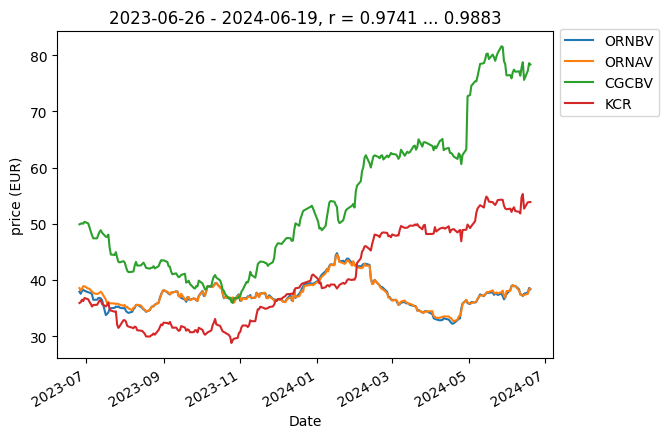

In [51]:
# Visualise:

r_min_query = 0.97 # <--- correlation minimum
r_max_query = 0.99 # <--- correlation maximum

start_date = '' # <--- inclusive start date, '' = from first data point in database
end_date = ''   # <--- inclusive end date, '' = until last data point in database

rescale_opt = 0 # <--- 1 = rescale the output to [0,1], 0 = don't

vis_corr_stocks(data_df,corr_id_r_df,start_date,end_date,r_min_query,r_max_query,rescale_opt)

#### Very high positive correlation:
For some pairs the prices are almost identical, and one of the lines is almost completely obscured by the other. In those cases in the figure, the stocks correspond to the same issuer. Another form of high correlation can be observed (CGCBV vs. KCR), where the prices have similar trends over several months despite having a substantial gap.
<br></br>
<br></br>

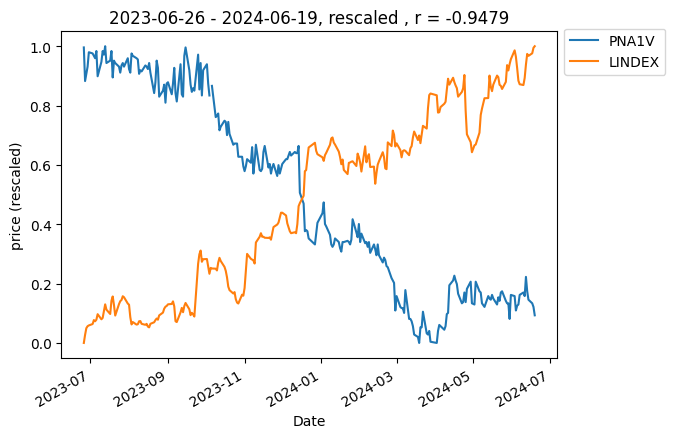

In [77]:
# Visualise:

r_min_query = -0.95 # <--- correlation minimum
r_max_query = -0.94 # <--- correlation maximum

start_date = '' # <--- inclusive start date, '' = from first data point in database
end_date = ''   # <--- inclusive end date, '' = until last data point in database

rescale_opt = 1 # <--- 1 = rescale the output to [0,1], 0 = don't

vis_corr_stocks(data_df,corr_id_r_df,start_date,end_date,r_min_query,r_max_query,rescale_opt)

#### Very high negative correlation:
These two stocks display opposite trends during the displayed year. However, it is important to note that at other time scales there might be positive correlation, with or without the trend removed.\
Note that prices data have been rescaled between 0 and 1 for better visualisation.
<br></br>
<br></br>

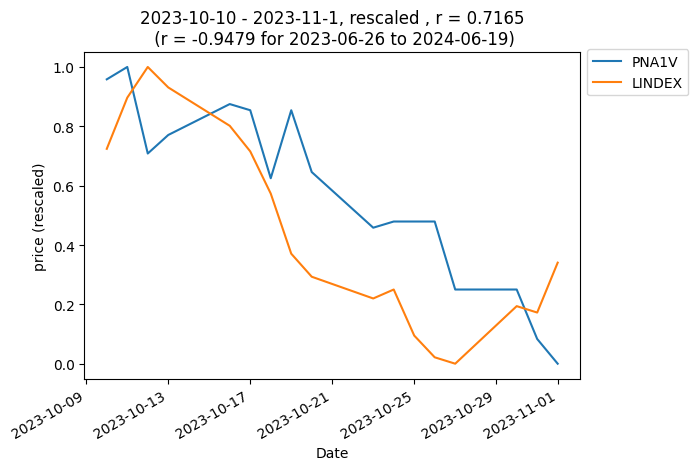

In [78]:
# Visualise:

r_min_query = -0.95 # <--- correlation minimum
r_max_query = -0.94 # <--- correlation maximum

start_date = '2023-10-10' # <--- inclusive start date, '' = from first data point in database
end_date = '2023-11-1'   # <--- inclusive end date, '' = until last data point in database

rescale_opt = 1 # <--- 1 = rescale the output to [0,1], 0 = don't

vis_corr_stocks(data_df,corr_id_r_df,start_date,end_date,r_min_query,r_max_query,rescale_opt)

#### Very high negative correlation on a one-year time-scale but positive correlation at a shorter time-scale.
Note that prices data have been rescaled between 0 and 1 for better visualisation.
<br></br>

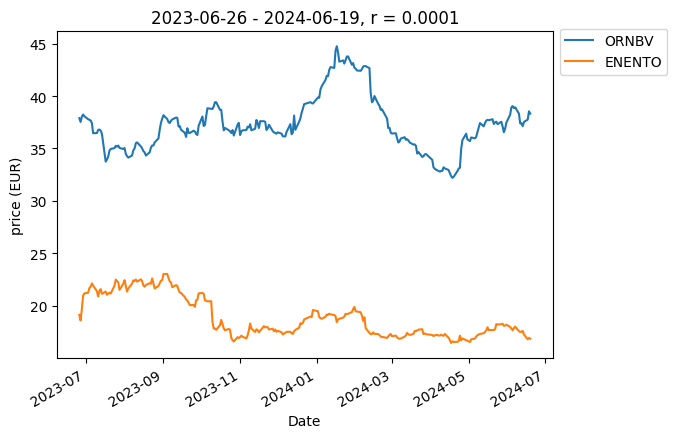

In [96]:
# Visualise:

r_min_query = 0 # <--- correlation minimum
r_max_query = 0.0001 # <--- correlation maximum

start_date = '' # <--- inclusive start date, '' = from first data point in database
end_date = ''   # <--- inclusive end date, '' = until last data point in database

rescale_opt = 0 # <--- 1 = rescale the output to [0,1], 0 = don't

vis_corr_stocks(data_df,corr_id_r_df,start_date,end_date,r_min_query,r_max_query,rescale_opt)

#### No correlation:
No or negligible correlation may be observed on a one-year time-scale. However, there are periods of mostly positive but also negative correlation within.
<br></br>
<br></br>

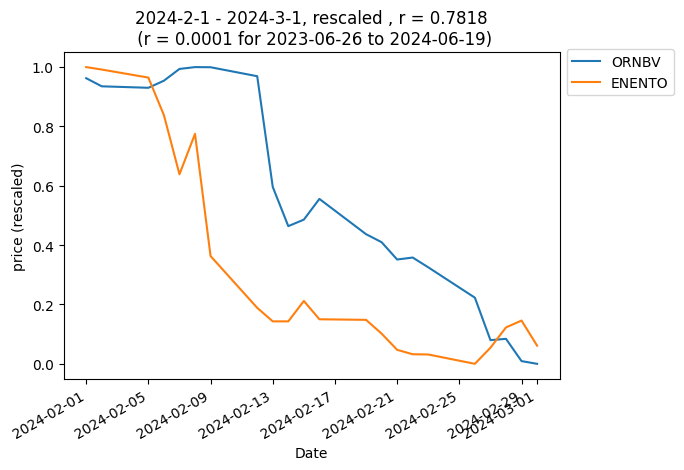

In [86]:
# Visualise:

r_min_query = 0 # <--- correlation minimum
r_max_query = 0.0001 # <--- correlation maximum

start_date = '2024-2-1' # <--- inclusive start date, '' = from first data point in database
end_date = '2024-3-1'   # <--- inclusive end date, '' = until last data point in database

rescale_opt = 1 # <--- 1 = rescale the output to [0,1], 0 = don't

vis_corr_stocks(data_df,corr_id_r_df,start_date,end_date,r_min_query,r_max_query,rescale_opt)

#### No correlation on a one-year time-scale but positive correlation at a shorter time-scale. 
Note that prices data have been rescaled between 0 and 1 for better visualisation.
<br></br>

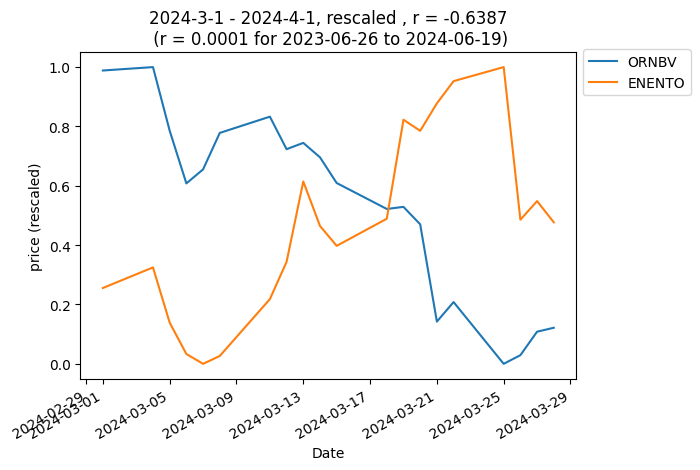

In [95]:
# Visualise:

r_min_query = 0 # <--- correlation minimum
r_max_query = 0.0001 # <--- correlation maximum

start_date = '2024-3-1' # <--- inclusive start date, '' = from first data point in database
end_date = '2024-4-1'   # <--- inclusive end date, '' = until last data point in database

rescale_opt = 1 # <--- 1 = rescale the output to [0,1], 0 = don't

vis_corr_stocks(data_df,corr_id_r_df,start_date,end_date,r_min_query,r_max_query,rescale_opt)

#### No correlation on a one-year time-scale but negative correlation at a shorter time-scale. 
Note that prices data have been rescaled between 0 and 1 for better visualisation.
<br></br>

In [97]:
connection.close()